## Imports

In [63]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marileonhardsen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

In [65]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[1040])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{'person': 'Bashar al-Assad',
                    'text': 'President',
                    'wdid': 'Q44329'},
                   {'person': 'Emile Hokayem', 'text': 'in Foreign Policy'},
                   {'person': 'Ahrar al Sham',
                    'text': 'the most important groups',
                    'wdid': 'Q860943'},
                   {'person': 'Vladimir Putin',
                    'text': 'Russian President',
                    'wdid': 'Q7747'},
                   {'person': 'Barack Obama',
                    'text': 'U.S. President',
                    'wdid': 'Q76'},
                   {'person': 'Osama Abu Zeid',
                    'text': 'a senior adviser to the moderate Free Syrian '
                            'Army'},
                   {'person': 'Op-Ed',
                    'text': 'for The Washington Post',
                    'wdid': 'Q2602337'},
                  

In [80]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

0  articles from ISIS War and  18561 articles from Brexit were loaded


In [81]:
# get only articles from one story, you can change this
articles = Brexit_articles

## Extract introductions, and obtain their sentiment

In [82]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

A Jupyter Widget

In [83]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 100)
for intro in subsample:
    if intro['sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])
        print("Source: ", intro["source"])

---------------
Entity mentionned: Tom Watson
the party 's former deputy chair
Sentiment: 0.4019
Source:  telegraph.co.uk
---------------
Entity mentionned: Remain Major
who are using the situation to try to reverse their defeat in the Referendum "
Sentiment: -0.4588
Source:  bbc.co.uk
---------------
Entity mentionned: Philippe Lamberts
who sits on the influential cross - party Brexit steering group
Sentiment: 0.6808
Source:  independent.co.uk
---------------
Entity mentionned: Jo Johnson
who heads up the new No 10 Policy Unit
Sentiment: -0.296
Source:  telegraph.co.uk
---------------
Entity mentionned: Tim Bowles
for the Conservative Party
Sentiment: 0.4019
Source:  telegraph.co.uk
---------------
Entity mentionned: Jeremy Corbyn
opposition Labour party Leader
Sentiment: 0.4019
Source:  independent.co.uk
---------------
Entity mentionned: Theresa May
leader of the Liberal Democrat Party Tim Farron and leader of the Labour Party Jeremy Corbyn
Sentiment: 0.6597
Source:  independent.co.

## Build a 2-dimensional object containing sentiment per entity, per source

In [84]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [85]:
# An example of how one entity (a city) is described by different sources

print(ent_source_sent['Hussain Osman'])

{'telegraph.co.uk': [0.2023, -0.8591, -0.743], 'independent.co.uk': [-0.5106]}


In [122]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['washingtonpost.com', 'telegraph.co.uk', 'theguardian.com', 'middleeasteye.net', 'france24.com', 'bloomberg.com', 'independent.co.uk', 'bbc.co.uk', 'techcrunch.com', 'wikinews.org', 'cnn.com', 'allafrica.com', 'chinadaily.com.cn', 'latimes.com', 'ap.org', 'aa.com.tr', 'businessinsider.in', 'foxnews.com', 'rt.com', 'reuters.com', 'aljazeera.com', 'nytimes.com']


## We create the array we will use in our sparse model

In [123]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.15
neg_threshold = -0.15

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 10028, 1: 2305, -1: 764})


In [124]:
print(source2j)

{'washingtonpost.com': 0, 'telegraph.co.uk': 1, 'theguardian.com': 2, 'middleeasteye.net': 3, 'france24.com': 4, 'bloomberg.com': 5, 'independent.co.uk': 6, 'bbc.co.uk': 7, 'techcrunch.com': 8, 'wikinews.org': 9, 'cnn.com': 10, 'allafrica.com': 11, 'chinadaily.com.cn': 12, 'latimes.com': 13, 'ap.org': 14, 'aa.com.tr': 15, 'businessinsider.in': 16, 'foxnews.com': 17, 'rt.com': 18, 'reuters.com': 19, 'aljazeera.com': 20, 'nytimes.com': 21}


## Model source similarity

In [125]:
# Write code that uses this matrix (entities, sources) to compute
# source similarity visible in bias of the way they describe entities

In [126]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A)


In [127]:
from numpy import linalg as LA 
LA.eigvals(np.dot(np.transpose(A_std), A_std))
LA.matrix_rank(np.dot(np.transpose(A_std), A_std))
summer = np.sum(A, axis = 0)
len(summer)
print(summer)
print(sources[8])
print(sources[9])

mask = 0 < summer
print(mask)
sources = np.array(sources)[mask]
print(sources)


[  48.  306.  212.    3.   84.  153.  124.   95.    0.    0.   69.    9.
   32.    5.   20.   28.   23.   56.    1.  182.   12.   79.]
techcrunch.com
wikinews.org
[ True  True  True  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True  True]
['washingtonpost.com' 'telegraph.co.uk' 'theguardian.com'
 'middleeasteye.net' 'france24.com' 'bloomberg.com' 'independent.co.uk'
 'bbc.co.uk' 'cnn.com' 'allafrica.com' 'chinadaily.com.cn' 'latimes.com'
 'ap.org' 'aa.com.tr' 'businessinsider.in' 'foxnews.com' 'rt.com'
 'reuters.com' 'aljazeera.com' 'nytimes.com']


In [128]:
A = A[:, mask]
A.shape

(4525, 20)

In [129]:
A_std = StandardScaler().fit_transform(A)

In [130]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.12)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(sources[i], sources[j])

bloomberg.com france24.com
bbc.co.uk telegraph.co.uk
bbc.co.uk theguardian.com
bbc.co.uk independent.co.uk
cnn.com washingtonpost.com
cnn.com france24.com
allafrica.com washingtonpost.com
chinadaily.com.cn middleeasteye.net
chinadaily.com.cn france24.com
chinadaily.com.cn bloomberg.com
chinadaily.com.cn cnn.com
latimes.com middleeasteye.net
latimes.com chinadaily.com.cn
ap.org washingtonpost.com
ap.org middleeasteye.net
ap.org france24.com
ap.org bloomberg.com
ap.org cnn.com
ap.org chinadaily.com.cn
ap.org latimes.com
aa.com.tr france24.com
aa.com.tr cnn.com
aa.com.tr chinadaily.com.cn
aa.com.tr ap.org
businessinsider.in middleeasteye.net
businessinsider.in aa.com.tr
foxnews.com washingtonpost.com
foxnews.com france24.com
foxnews.com cnn.com
foxnews.com chinadaily.com.cn
foxnews.com latimes.com
foxnews.com ap.org
foxnews.com aa.com.tr
reuters.com washingtonpost.com
reuters.com theguardian.com
reuters.com france24.com
reuters.com bloomberg.com
reuters.com independent.co.uk
reuters.com b

## Workspace

In [131]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [132]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

0.1


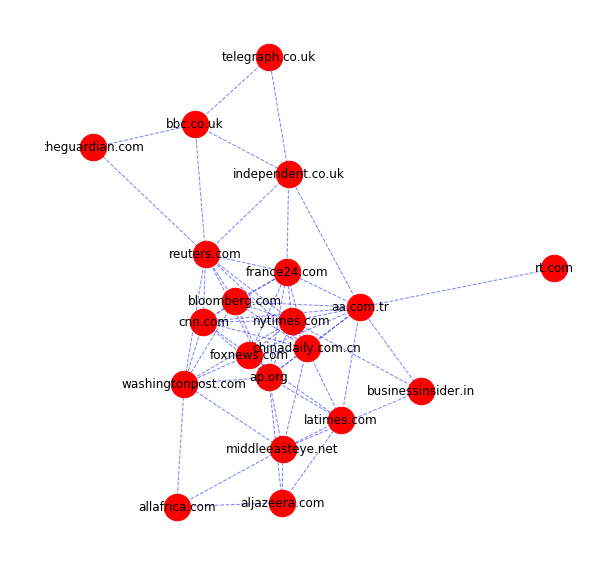

0.11


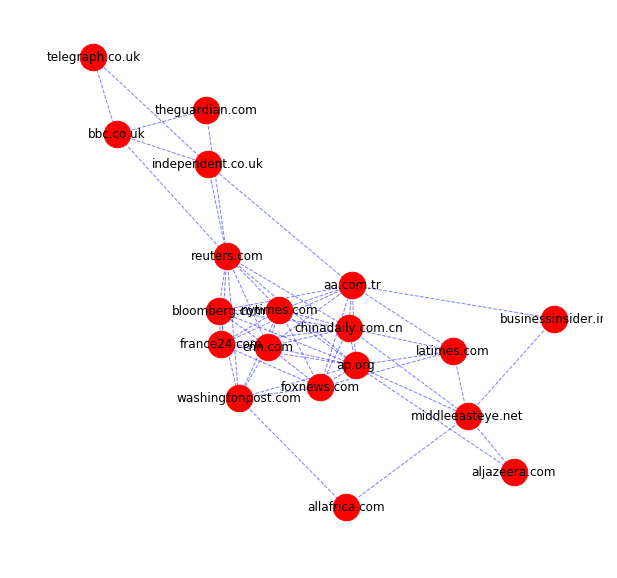

0.12


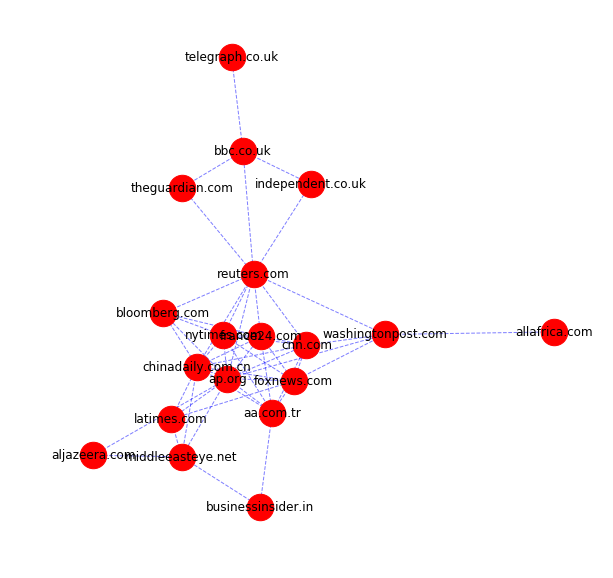

0.13


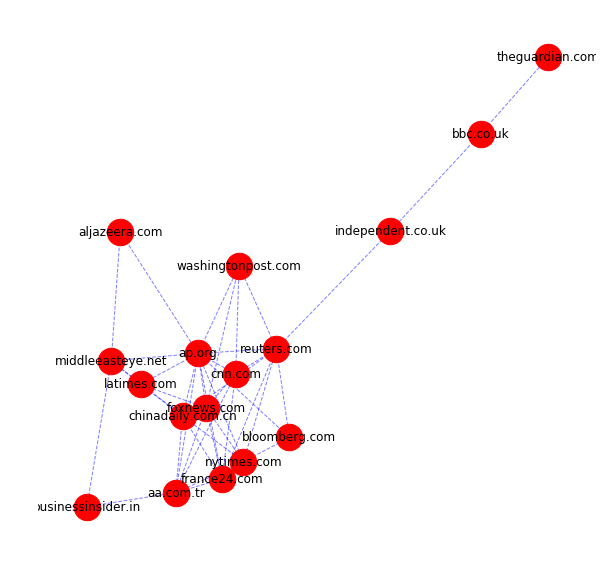

0.14


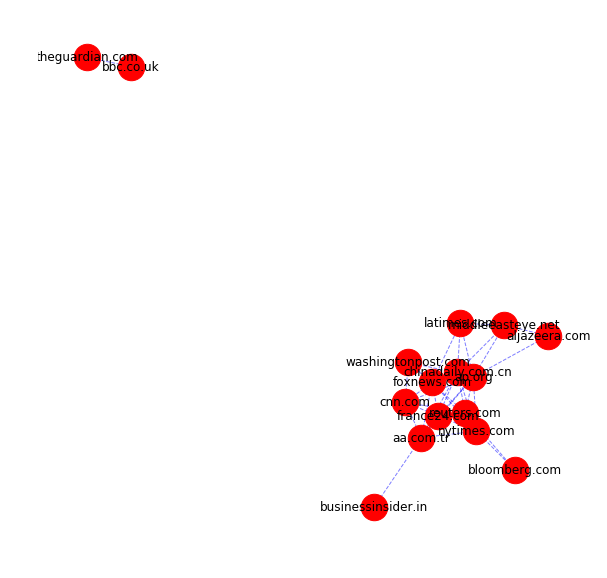

0.15


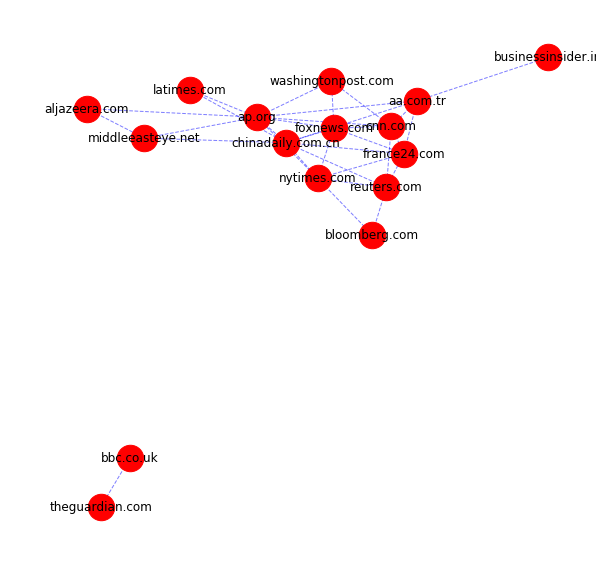

0.16


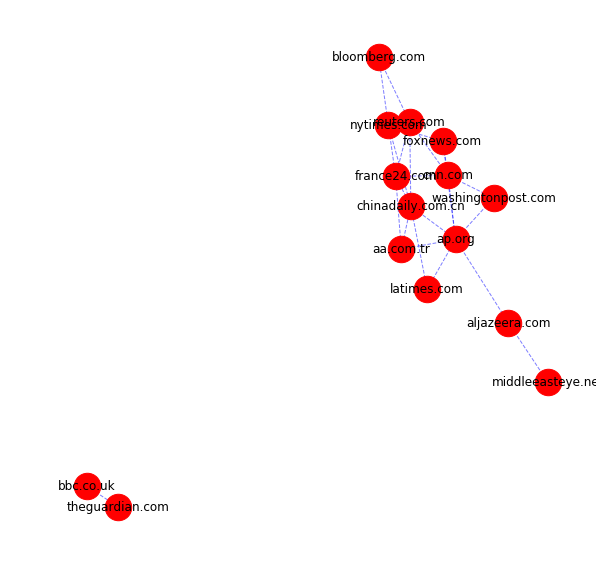

0.17


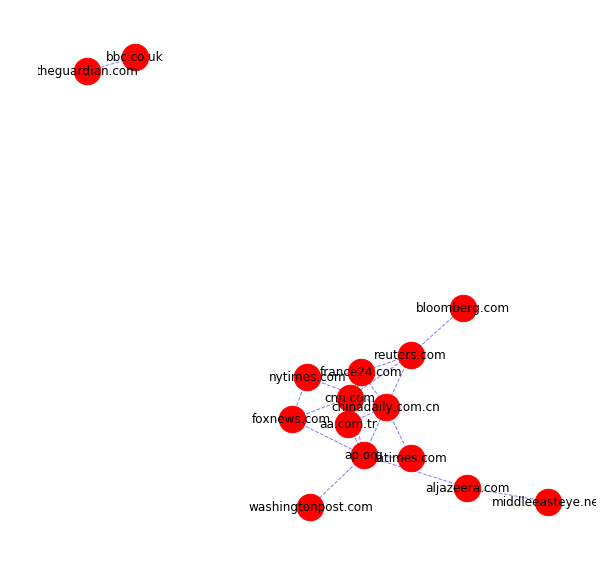

0.18


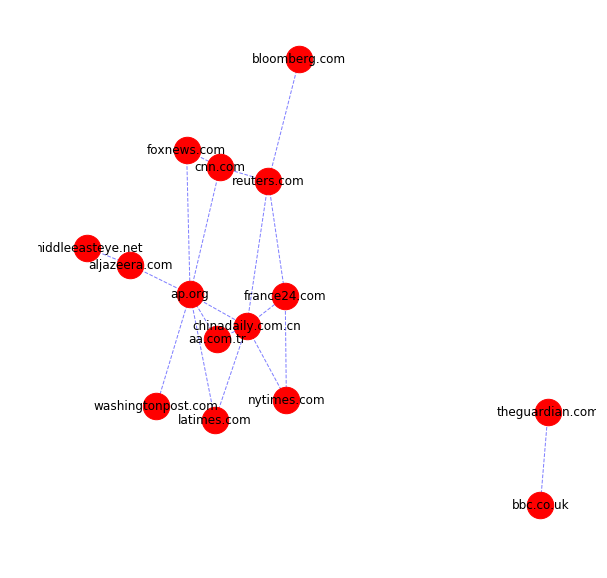

0.19


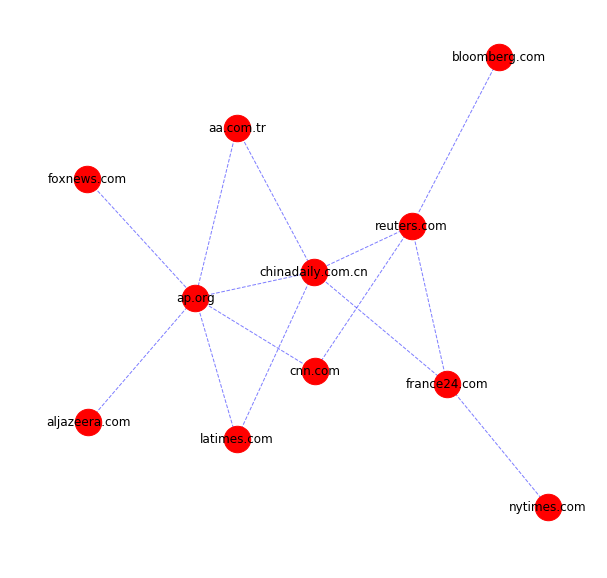

In [133]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    graph_lasso = GraphLasso(alpha=l1_lambda)
    graph_lasso.fit(A_std)
    plot_network(graph_lasso.get_precision(), sources)

In [134]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

0.1


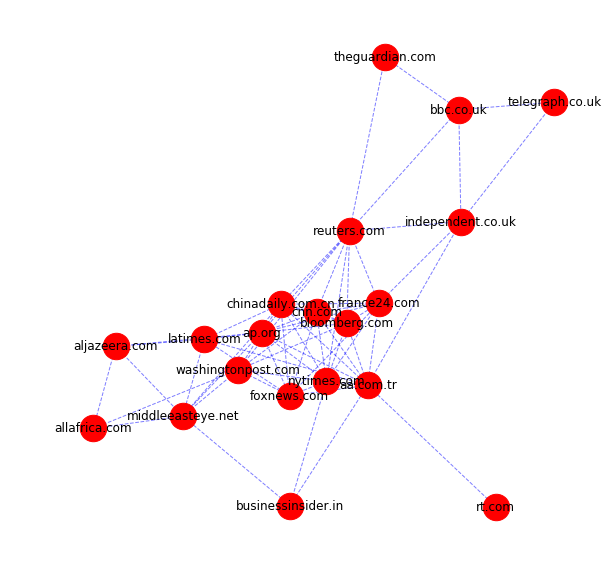

0.11


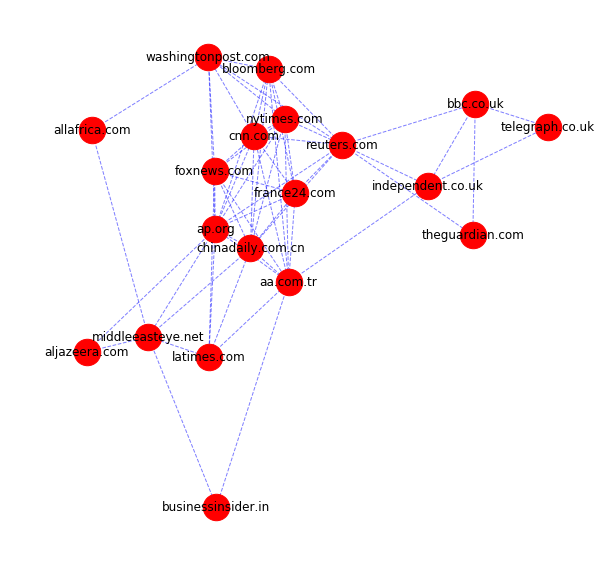

0.12


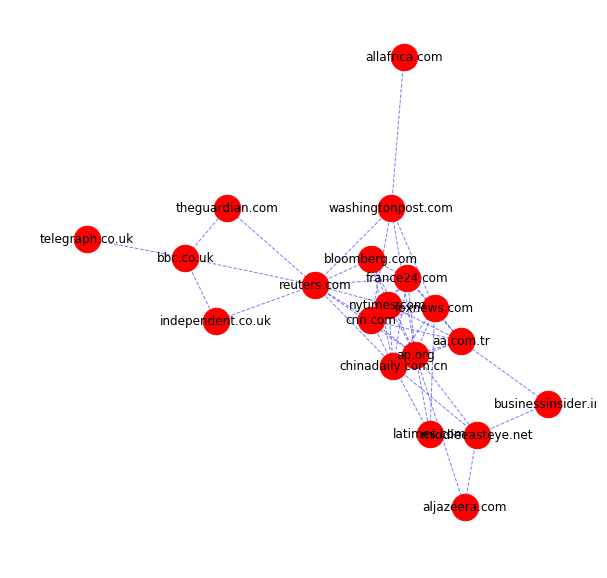

0.13


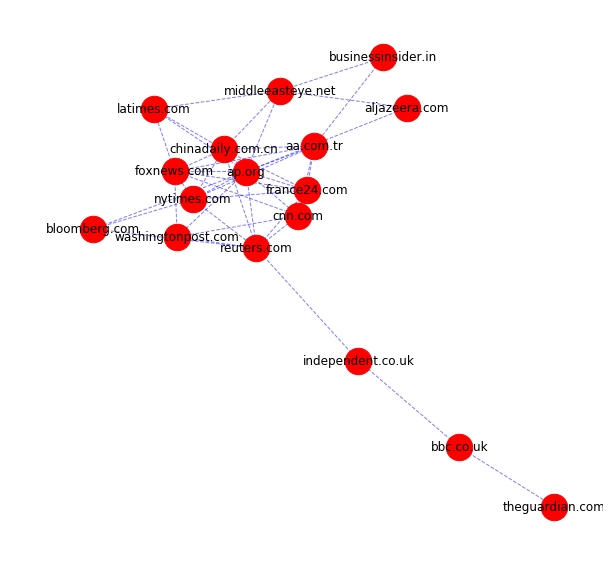

0.14


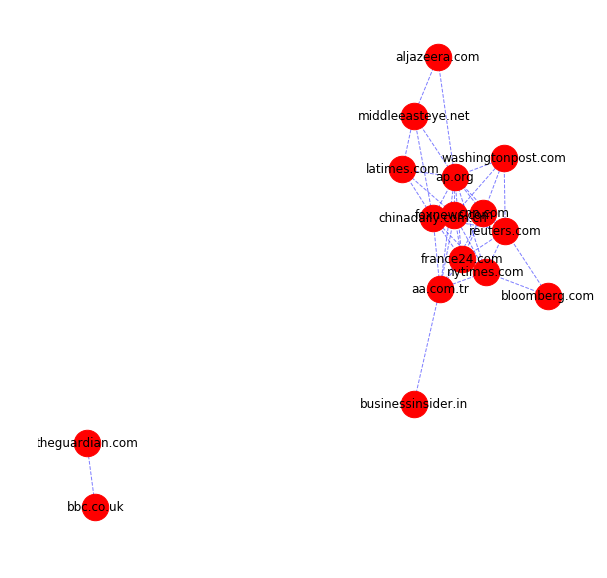

0.15


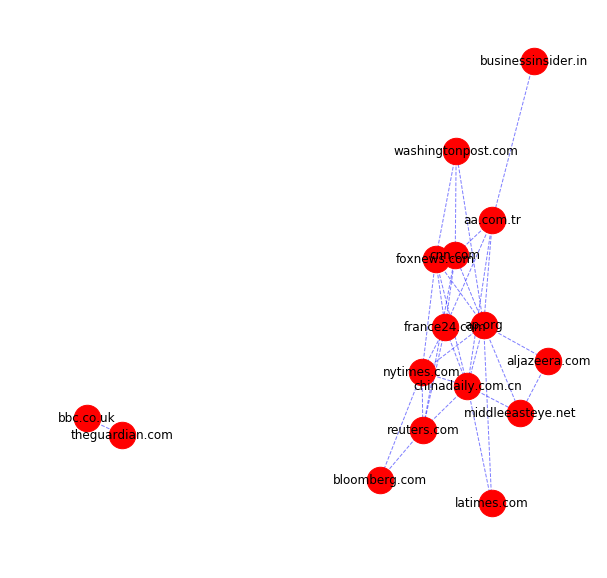

0.16


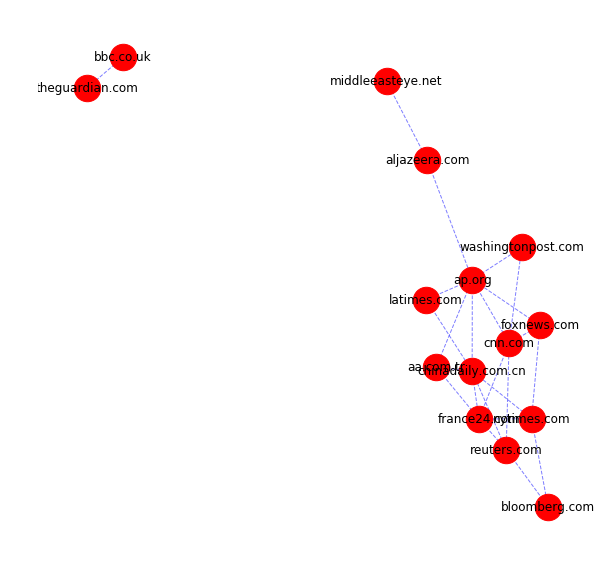

0.17


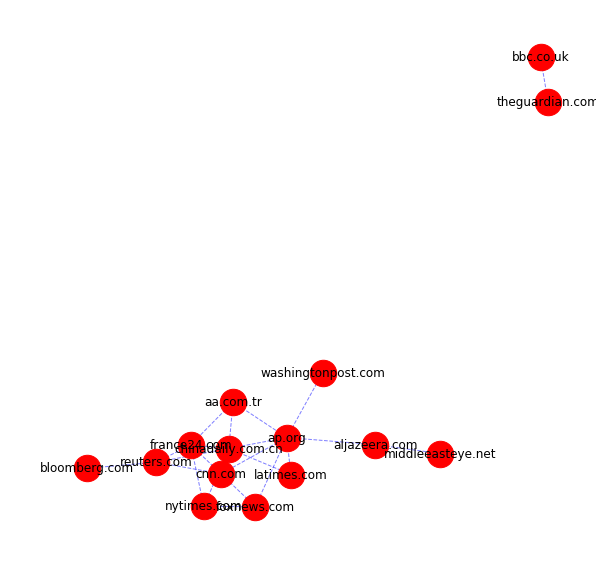

0.18


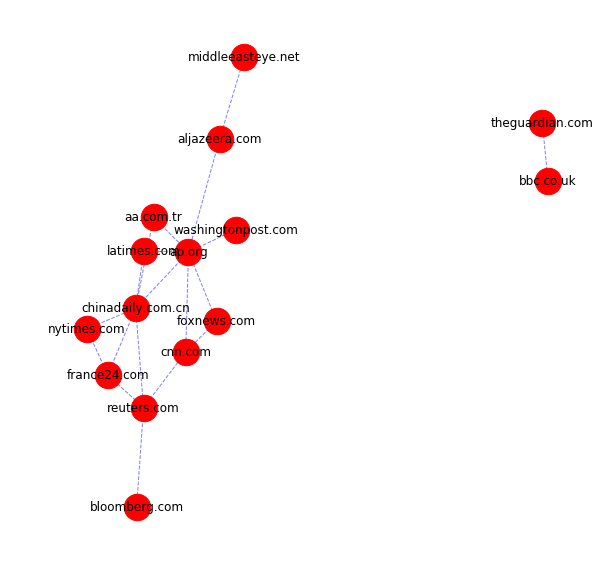

0.19


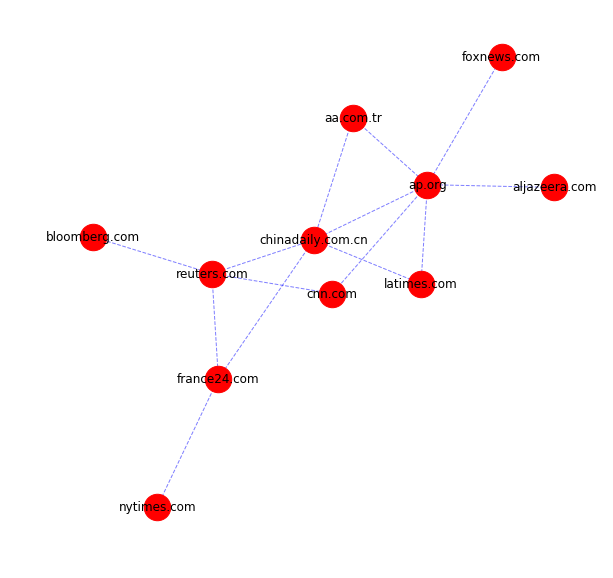

In [135]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(my_graphical_lasso(A_std, l1_lambda), sources)

## Our Glasso: best by inspection

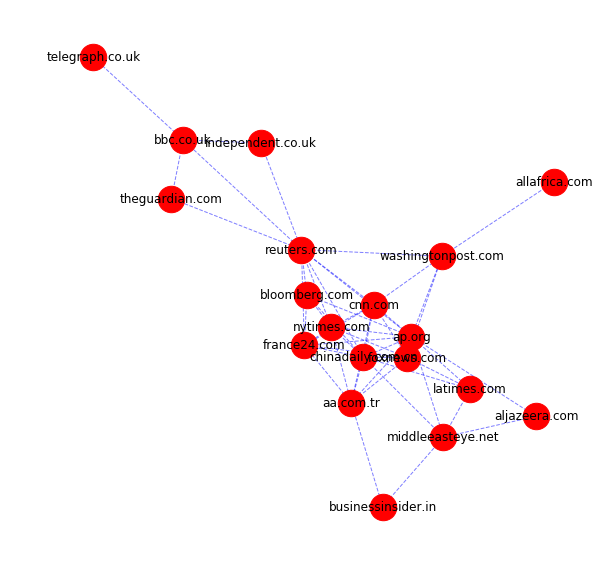

In [136]:
plot_network(my_graphical_lasso(A_std, l1_lambda=0.12), sources)

## Neighborhood method

In [137]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso

In [138]:
n_sel = NGraphSelection(Lasso)
g = n_sel.fit(A_std, 0.1, 'AND')

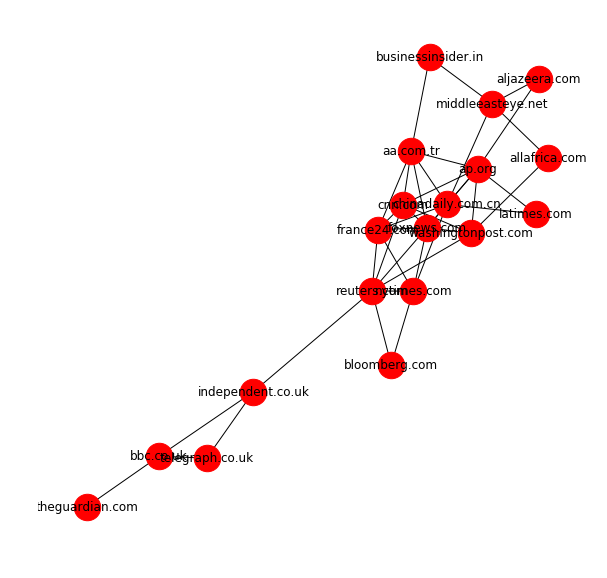

In [139]:
plot_network(g, sources)

## Neighborhood method w/own Lasso implementation (not correct)

In [140]:
from Lasso import Lasso2
n_sel = NGraphSelection(Lasso2)
g = n_sel.fit(A_std, 0.1, 'AND')

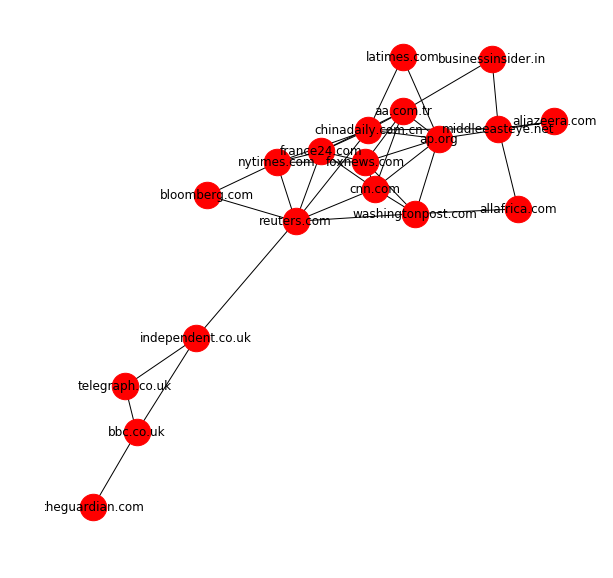

In [141]:
plot_network(g, sources)